In [1]:
from dataclasses import dataclass

@dataclass
class TrainingConfig:
    image_size = 2  # the generated image resolution
    model_id = 1
    train_batch_size = 100  # how many images to sample during training
    eval_batch_size = 100  # how many images to sample during evaluation
    num_epochs = 50
    patience = 200  # early stopping patience
    gradient_accumulation_steps = 1
    learning_rate = 1e-3
    lr_warmup_steps = 50
    save_image_epochs = 10
    save_model_epochs = 30
    output_dir = f"saved_models/run_{model_id}/"  # the model name locally and on the HF Hub



config = TrainingConfig()

# Construct the dataset

In [ ]:
import torch
from torch.utils.data import Dataset, ConcatDataset
import numpy as np
from tqdm import tqdm
from diffusers.optimization import get_cosine_schedule_with_warmup
from diffusers import DDPMScheduler
import torch.nn.functional as F

class GaussianDataset(Dataset):
    def __init__(self, num_samples, input_dim, cov, samples_per_obs, obs_trans = None):
        self.num_samples = num_samples
        self.input_dim = input_dim
        self.cov = cov

        self.o = []
        self.a = []
        # Generate input data (o)
        for _ in range(num_samples):
            obs = np.random.normal(size=(input_dim))
            if obs_trans is not None:
                mu = obs_trans(obs)
            else:
                mu = obs

            for _ in range(samples_per_obs):

                # Generate output data (a) using the Gaussian distribution
                act = np.random.multivariate_normal(mean=mu, cov=self.cov)

                self.o.append(obs)
                self.a.append(act)

        print(f"Generated {len(self.o)} samples")


    def __len__(self):
        return len(self.o)
    
    def get_observations(self):
        return self.o

    def __getitem__(self, idx):
        o = torch.tensor(self.o[idx], dtype=torch.float32)
        a = torch.tensor(self.a[idx], dtype=torch.float32)
        return o, a
    
def generate_random_cov_matrix(dim, seed=None):
    if seed is not None:
        np.random.seed(seed)

    # Generate a random matrix
    A = np.random.normal(size=(dim, dim))

    # Make the matrix symmetric
    A = np.triu(A) + np.triu(A, 1).T

    # Make the matrix positive semi-definite
    cov_matrix = np.dot(A, A.T)

    return cov_matrix

def get_sim_trans(seed_A=None, seed_B=None, mag=0.5):
    if seed_A is not None:
        A = seed_A
    else:
        A = np.eye(config.image_size) + np.random.uniform(low=-mag, high=mag, size=(config.image_size, config.image_size))
        print(A.shape)
        np.savetxt(f"A{config.model_id}.csv", A, delimiter=",")
    if seed_B is not None:
        B = seed_B
    else:
        B = np.random.uniform(low=-mag, high=mag, size=(config.image_size, 1)).flatten()
        print(B.shape)
        np.savetxt(f"B{config.model_id}.csv", B, delimiter=",")


    def trans_func(x):
        return ((np.dot(A, x[:, np.newaxis])).flatten() + B)
    
    return trans_func

/home/rbosworth/DiffusionCoTrainingToy/diffusion_toy/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# Set parameters

action_dim = 2
cov = generate_random_cov_matrix(action_dim)
sim_cov = cov + generate_random_cov_matrix(action_dim) * 0.2
samples_per_obs = 1
real_samples = int(10000 / samples_per_obs)
sim_saples = int(10000 / samples_per_obs)

sim_trans_func = get_sim_trans()

"""
Load dataset

"""

# cov = np.loadtxt(f"{config.output_dir}cov-{config.model_id}.csv", delimiter=",")
# sim_cov = np.loadtxt(f"{config.output_dir}sim_cov-{config.model_id}.csv", delimiter=",")
# A_val = np.loadtxt(f"A{config.model_id}.csv", delimiter=",")
# b_val = np.loadtxt(f"B{config.model_id}.csv", delimiter=",")
# sim_trans_func = get_sim_trans(A_val, b_val)

(2, 2)
(2,)


'\nLoad dataset\n\n'

In [4]:


np.savetxt(f"{config.output_dir}cov-{config.model_id}.csv", cov, delimiter=",")
np.savetxt(f"{config.output_dir}sim_cov-{config.model_id}.csv", sim_cov, delimiter=",")

# example of how to use the transformation function
print(sim_trans_func(np.array([1, 2])))

# Create dataset
real_dataset = GaussianDataset(real_samples, action_dim, cov, samples_per_obs)

sim_dataset = GaussianDataset(sim_saples, action_dim, sim_cov, samples_per_obs, obs_trans=sim_trans_func)

val_dataset = GaussianDataset(100, action_dim, cov, samples_per_obs)
# Create data loader
batch_size = config.train_batch_size

val_data_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

for step, batch in enumerate(val_dataset):
    o, a = batch
    print(o.shape, a.shape)
    break

# Construct validation dataset


[1.25520238 0.93728713]
Generated 10000 samples
Generated 10000 samples
Generated 100 samples
torch.Size([2]) torch.Size([2])


In [5]:
torch.save(val_dataset, f"{config.output_dir}val_data_set-{config.model_id}.pt")

## Plots the dataset

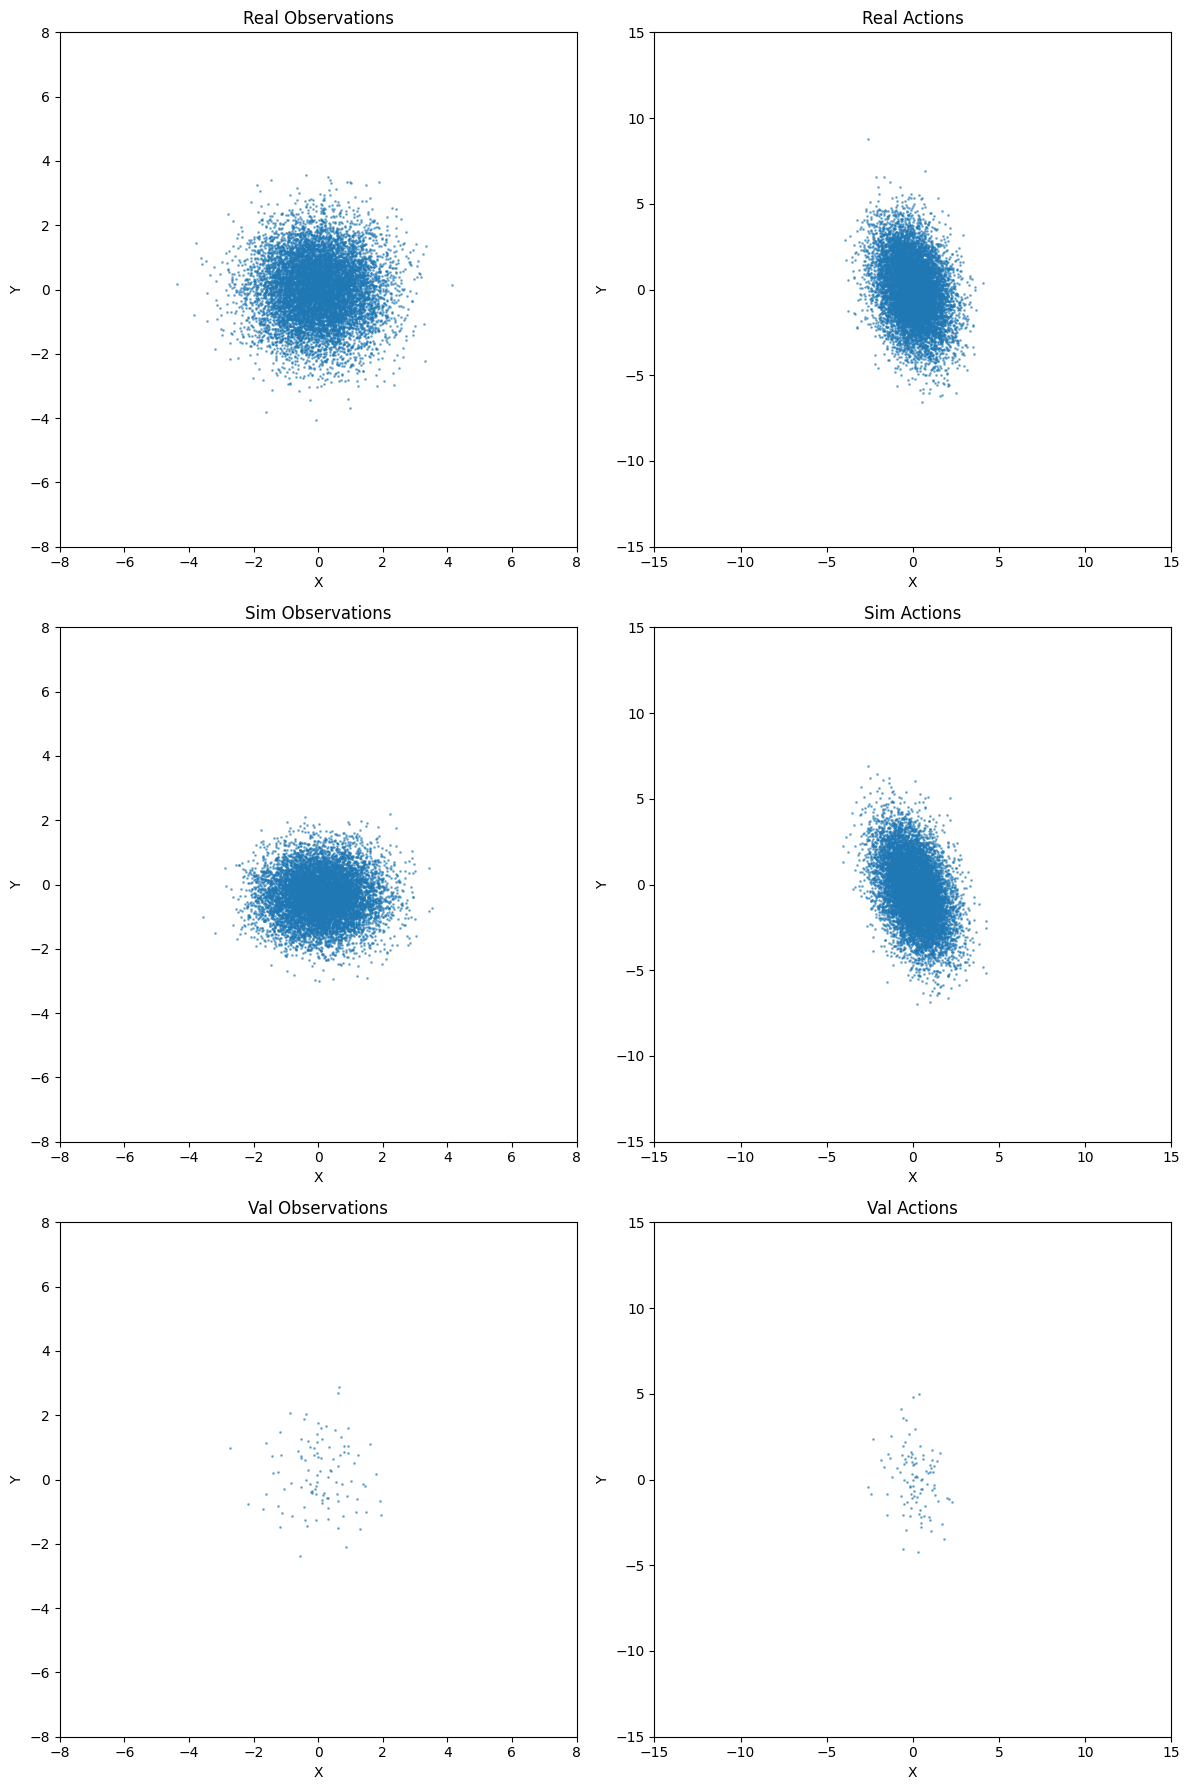

In [6]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

real_obs = np.array([o for o, _ in real_dataset])
real_act = np.array([a for _, a in real_dataset])

sim_obs = np.array([o for o, _ in sim_dataset])
sim_act = np.array([a for _, a in sim_dataset])

val_obs = np.array([o for o, _ in val_dataset])
val_act = np.array([a for _, a in val_dataset])

# Create a figure with 3 rows and 2 columns
plt.figure(figsize=(12, 18))

# Real dataset

plt.subplot(3, 2, 1)
plt.scatter(real_obs[:, 0], real_obs[:, 1], s=1, alpha=0.5)
plt.title("Real Observations")
plt.xlabel("X")
plt.ylabel("Y")
plt.xlim(-8, 8)
plt.ylim(-8, 8)

plt.subplot(3, 2, 2)
plt.scatter(real_act[:, 0], real_act[:, 1], s=1, alpha=0.5)
plt.title("Real Actions")
plt.xlabel("X")
plt.ylabel("Y")
plt.xlim(-15, 15)
plt.ylim(-15, 15)

# Sim dataset
plt.subplot(3, 2, 3)
plt.scatter(sim_obs[:, 0], sim_obs[:, 1], s=1, alpha=0.5)
plt.title("Sim Observations")
plt.xlabel("X")
plt.ylabel("Y")
plt.xlim(-8, 8)
plt.ylim(-8, 8)

plt.subplot(3, 2, 4)
plt.scatter(sim_act[:, 0], sim_act[:, 1], s=1, alpha=0.5)
plt.title("Sim Actions")
plt.xlabel("X")
plt.ylabel("Y")
plt.xlim(-15, 15)
plt.ylim(-15, 15)

# Val dataset
plt.subplot(3, 2, 5)
plt.scatter(val_obs[:, 0], val_obs[:, 1], s=1, alpha=0.5)
plt.title("Val Observations")
plt.xlabel("X")
plt.ylabel("Y")
plt.xlim(-8, 8)
plt.ylim(-8, 8)

plt.subplot(3, 2, 6)
plt.scatter(val_act[:, 0], val_act[:, 1], s=1, alpha=0.5)
plt.title("Val Actions")
plt.xlabel("X")
plt.ylabel("Y")
plt.xlim(-15, 15)
plt.ylim(-15, 15)

plt.tight_layout()
plt.show()

# Construct the Neural Network

In [7]:
import torch.nn as nn
from diffusers import UNet2DModel

import torch
import torch.nn as nn
import torch.nn.functional as F


class TimeEmbedding(nn.Module):
    def __init__(self, embedding_dim, max_period=10000):
        super().__init__()
        self.embedding_dim = embedding_dim
        self.max_period = max_period

    def forward(self, t):
        half_dim = self.embedding_dim // 2
        emb = torch.cat([torch.sin(t * (10000 ** (torch.arange(half_dim, device=t.device) / half_dim))), 
                        torch.cos(t * (10000 ** (torch.arange(half_dim, device=t.device) / half_dim)))], dim=-1)
        return emb

class ClassConditionedMLP(nn.Module):
    def __init__(self, action_dim=2, class_emb_size=2, hidden_dim=64, num_layers=3, time_emb_dim=128):
        super().__init__()
        
        self.time_embedding = TimeEmbedding(time_emb_dim)

        self.time_embedding_transform = nn.Linear(time_emb_dim, action_dim)
        
        # Input dimension: (action_dim + class_emb_size) + time_emb_dim
        input_dim = action_dim * 1 + class_emb_size * 1 + action_dim
        output_dim = action_dim * 1  # Matches the output shape of the UNet
        
        # Define a simple MLP architecture
        layers = [nn.Linear(input_dim, hidden_dim), nn.ReLU()]
        for _ in range(num_layers - 1):
            layers.extend([nn.Linear(hidden_dim, hidden_dim), nn.ReLU()])
        layers.append(nn.Linear(hidden_dim, output_dim))
        
        self.mlp = nn.Sequential(*layers)
    
    def forward(self, obs, act, t):
        # Flatten input dimensions and prepare input for MLP
        act = torch.tensor(act).unsqueeze(1).unsqueeze(-1)  # Convert to tensor and shape (bs, 1, 2, 1)
        bs, ch, w, h = act.shape
        act_flat = act.view(bs, -1)  # Flatten to (bs, action_dim)
        
        class_cond = torch.tensor(obs)  # Convert to tensor (bs, class_emb_size)
        
        # Encode timestep
        t = torch.tensor(t).unsqueeze(-1)  # Convert timestep to tensor (bs, 1)

        t_emb = self.time_embedding_transform(self.time_embedding(t))  # Encode timestep
        
        # Concatenate action, class conditioning, and encoded timestep
        mlp_input = torch.cat([act_flat, class_cond, t_emb], dim=1)  # Shape: (bs, input_dim)
        
        # Pass through MLP
        output = self.mlp(mlp_input)  # Shape: (bs, output_dim)
        
        # Reshape to match UNet's output: (bs, 1, action_dim, 1)
        return output.view(bs, 1, w, h)


class ClassConditionedUnet(nn.Module):
    def __init__(self, action_dim=2, class_emb_size=2):
        super().__init__()

        # Self.model is an unconditional UNet with extra input channels to accept the conditioning information (the class embedding)
        self.model = UNet2DModel(
            sample_size=(action_dim, 1),  # the target image resolution
            in_channels=1 + class_emb_size,  # Additional input channels for class cond.
            out_channels=1,  # the number of output channels
            block_out_channels=(32,),
            down_block_types=(
                "DownBlock2D",  # a regular ResNet downsampling block
            ),
            up_block_types=(
                "UpBlock2D",  # a regular ResNet upsampling block
            ),
        )

    # Our forward method now takes the class labels as an additional argument
    def forward(self, obs, act, t):
        act = torch.Tensor(act).unsqueeze(1).unsqueeze(-1)  # Convert to tensor and move to device
        # Shape of x:
        bs, ch, w, h = act.shape

        # class conditioning in right shape to add as additional input channels
        class_cond = torch.Tensor(obs) # Convert to tensor and move to device
        class_cond = class_cond.view(bs, class_cond.shape[1], 1, 1).expand(bs, class_cond.shape[1], w, h)
        # x is shape (bs, 1, 2, 1) and class_cond is now (bs, 2, 2, 1)

        # Net input is now x and class cond concatenated together along dimension 1
        net_input = torch.cat((act, class_cond), 1)  # (bs, 3, 2, 1)

        # Feed this to the UNet alongside the timestep and return the prediction
        return self.model(net_input, t).sample  # (bs, 1, 2, 1)

# Initialize the MLP with the desired action dimension
model = ClassConditionedMLP(action_dim=action_dim)

# Print the MLP architecture
print(model)

print(f"Number of trainable weights: {sum(p.numel() for p in model.parameters() if p.requires_grad)}")

ClassConditionedMLP(
  (time_embedding): TimeEmbedding()
  (time_embedding_transform): Linear(in_features=128, out_features=2, bias=True)
  (mlp): Sequential(
    (0): Linear(in_features=6, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=64, bias=True)
    (5): ReLU()
    (6): Linear(in_features=64, out_features=2, bias=True)
  )
)
Number of trainable weights: 9156


In [9]:


noise_scheduler = DDPMScheduler(num_train_timesteps=1000)

optimizer = torch.optim.AdamW(model.parameters(), lr=config.learning_rate)
lr_scheduler = get_cosine_schedule_with_warmup(
    optimizer=optimizer,
    num_warmup_steps=config.lr_warmup_steps,
    num_training_steps=(len(data_loader) * config.num_epochs),
)

alphas_cum_prod = noise_scheduler.alphas_cumprod
alphas = noise_scheduler.alphas

np.savetxt(f"{config.output_dir}alphas_cum_prod-{config.model_id}.csv", alphas_cum_prod.numpy())
np.savetxt(f"{config.output_dir}alphas-{config.model_id}.csv", alphas.numpy())

NameError: name 'data_loader' is not defined

# Train the policy

In [8]:
from accelerate import Accelerator
from huggingface_hub import create_repo, upload_folder
from tqdm.auto import tqdm
from pathlib import Path
import os
from diffusers import DDPMPipeline
from diffusers.utils import make_image_grid
import os
import wandb
import torch
import torch.nn.functional as F




def train_loop(config, model, noise_scheduler, optimizer, train_dataloader, val_dataloader, lr_scheduler):
    # Initialize accelerator and tensorboard logging
    accelerator = Accelerator(
        gradient_accumulation_steps=config.gradient_accumulation_steps,
        project_dir=os.path.join(config.output_dir, "logs"),
    )
    if accelerator.is_main_process:
        if config.output_dir is not None:
            os.makedirs(config.output_dir, exist_ok=True)

    # Prepare everything
    # There is no specific order to remember, you just need to unpack the
    # objects in the same order you gave them to the prepare method.
    model, optimizer, train_dataloader, val_dataloader, lr_scheduler = accelerator.prepare(
        model, optimizer, train_dataloader, val_dataloader, lr_scheduler
    )

    global_step = 0

    epochs_since_improvement = 0

    prev_val_loss = float("inf")

    # Now you train the model
    for epoch in range(config.num_epochs):
        progress_bar = tqdm(total=len(train_dataloader), disable=not accelerator.is_local_main_process)
        progress_bar.set_description(f"Epoch {epoch}")
        train_loss = 0

        for step, batch in enumerate(train_dataloader):
            # Unpack the batch
            obs, act = batch
            # Concatenate observation and action
            bs = obs.shape[0]

            # Sample noise to add to the actions
            noise = torch.randn(act.shape, device=act.device)

            # Sample a random timestep for each action
            timesteps = torch.randint(
                0, noise_scheduler.config.num_train_timesteps, (bs,), device=act.device,
                dtype=torch.int64
            )

            # Add noise to the clean actions according to the noise magnitude at each timestep
            # (this is the forward diffusion process)
            noisy_actions = noise_scheduler.add_noise(act, noise, timesteps)

            
            
            with accelerator.accumulate(model):
                # Predict the noise residual
                noise_pred = model(obs, noisy_actions, timesteps).squeeze()

                loss = F.mse_loss(noise_pred, noise)
                train_loss += loss.detach().item()
                accelerator.backward(loss)

                if accelerator.sync_gradients:
                    accelerator.clip_grad_norm_(model.parameters(), 1.0)
                optimizer.step()
                lr_scheduler.step()
                optimizer.zero_grad()

            progress_bar.update(1)

            logs = {"loss": loss.detach().item(), "step": global_step}
            wandb.log(logs)
            
            
            global_step += 1

        train_loss /= len(train_dataloader)

        # Validate after each epoch
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for batch in val_dataloader:
                obs, act = batch
                bs = obs.shape[0]

                noise = torch.randn(act.shape, device=act.device)
                timesteps = torch.randint(
                    0, noise_scheduler.config.num_train_timesteps, (bs,), device=act.device,
                    dtype=torch.int64
                )
                noisy_actions = noise_scheduler.add_noise(act, noise, timesteps)
                noise_pred = model(obs, noisy_actions, timesteps).squeeze()
                test_loss = F.mse_loss(noise_pred, noise)
                val_loss += test_loss.detach().item()

        val_loss /= len(val_dataloader)

        logs = {"train-loss": train_loss, "val-loss": val_loss, "lr": lr_scheduler.get_last_lr()[0], "step": global_step}
        wandb.log(logs)
        progress_bar.set_postfix(**logs)

        if val_loss < prev_val_loss:
            prev_val_loss = val_loss
            epochs_since_improvement = 0
        else:
            epochs_since_improvement += 1

        if epochs_since_improvement >= config.patience:
            print(f"Early stopping at epoch {epoch}")
            break

        # Save the model after each epoch
        if accelerator.is_main_process and epoch % config.save_model_epochs == 0:
            ...
            #pipeline = DDPMPipeline(unet=accelerator.unwrap_model(model.model), scheduler=noise_scheduler)
            #pipeline.save_pretrained(config.output_dir)

        model.train()

In [9]:

from accelerate import notebook_launcher
args = (config, model, noise_scheduler, optimizer, data_loader, val_data_loader, lr_scheduler)
notebook_launcher(train_loop, args, num_processes=1)

torch.save(model, f"saved_models/MLP-model-{config.model_id}.pth")

NameError: name 'noise_scheduler' is not defined

# Run Several Inf Trials

In [9]:
from accelerate import notebook_launcher
from torch.utils.data import Subset
from diffusers.optimization import get_cosine_schedule_with_warmup
from diffusers import DDPMScheduler
import torch.nn.functional as F
# Define the combinations of real and simulated data
combinations = []
num_batches = 1
for i in range(num_batches + 1):
    start_idx = int(i / num_batches * len(real_dataset))
    percent_real = i / num_batches
    combinations.append({"start_idx": start_idx, "percent_real": percent_real})

In [10]:


for combination in combinations:
    wandb.init(project="diffusion-toy", entity="rohanb27-csail")

    start_idx = combination["start_idx"]
    percent_real = combination["percent_real"]

    model_combin = ClassConditionedMLP()

    # Create subsets of the datasets
    real_subset = Subset(real_dataset, range(start_idx))
    sim_subset = Subset(sim_dataset, range(start_idx, len(sim_dataset)))

    # Concatenate the subsets
    dataset_combin = ConcatDataset([real_subset, sim_subset])


    print(f"Training with {percent_real * 100}% real data")
    print(f"length of dataset: {len(dataset_combin)}")

    data_loader_combin = torch.utils.data.DataLoader(dataset_combin, batch_size=config.train_batch_size, shuffle=True)
    noise_scheduler_combin = DDPMScheduler(num_train_timesteps=1000)

    optimizer_combin = torch.optim.AdamW(model.parameters(), lr=config.learning_rate)
    lr_scheduler_combin = get_cosine_schedule_with_warmup(
        optimizer=optimizer_combin,
        num_warmup_steps=config.lr_warmup_steps,
        num_training_steps=(len(data_loader_combin) * config.num_epochs),
    )

    args = (config, model_combin, noise_scheduler_combin, optimizer_combin, data_loader_combin, val_data_loader, lr_scheduler_combin)
    notebook_launcher(train_loop, args, num_processes=1)

    torch.save(model_combin, f"saved_models/MLP-model-{config.model_id} - {percent_real}% real data.pth")

    config.model_id += 1


wandb: Currently logged in as: rohanb27 (rohanb27-csail). Use `wandb login --relogin` to force relogin
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


Training with 0.0% real data
length of dataset: 10000
Launching training on one GPU.


Epoch 0:   0%|          | 0/100 [00:00<?, ?it/s]/tmp/ipykernel_627997/752194290.py:43: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  act = torch.tensor(act).unsqueeze(1).unsqueeze(-1)  # Convert to tensor and shape (bs, 1, 2, 1)
/tmp/ipykernel_627997/752194290.py:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  class_cond = torch.tensor(obs)  # Convert to tensor (bs, class_emb_size)
/tmp/ipykernel_627997/752194290.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t = torch.tensor(t).unsqueeze(-1)  # Convert timestep to tensor (bs, 1)


Training with 100.0% real data
length of dataset: 10000
Launching training on one GPU.


Epoch 0:   0%|          | 0/100 [00:00<?, ?it/s]/tmp/ipykernel_627997/752194290.py:43: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  act = torch.tensor(act).unsqueeze(1).unsqueeze(-1)  # Convert to tensor and shape (bs, 1, 2, 1)
/tmp/ipykernel_627997/752194290.py:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  class_cond = torch.tensor(obs)  # Convert to tensor (bs, class_emb_size)
/tmp/ipykernel_627997/752194290.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t = torch.tensor(t).unsqueeze(-1)  # Convert timestep to tensor (bs, 1)


In [ ]:
# @markdown Sampling some different digits:
import torch
from diffusers import DDPMScheduler

device = "cuda" if torch.cuda.is_available() else "cpu"
model = torch.load("saved_models/MLP-model.pth").to(device)
noise_scheduler = DDPMScheduler(num_train_timesteps=1000, clip_sample=False)

# TBD: compute function for optimal solution
alphas_cum_prod = noise_scheduler.alphas_cumprod

model.eval()

# Prepare random x to start from, plus some desired labels y
# obs, act_desired = sim_dataset[0:2]

obs = torch.tensor([[-2.8121,  1.9047],
        [-2.8121,  1.9047], [-2.8121,  1.9047]])
act_desired = torch.tensor([[-2.8110,  1.8979],
        [-2.6461,  1.8752]])

obs = torch.tensor([[2.5,  2.5],
        [-2.5,  2.5], [2.5,  -2.5]])
act_desired = torch.tensor([[-2.8110,  1.8979],
        [-2.6461,  1.8752]])

act = torch.randn(3, 2)
#act = torch.tensor([[-2.8121,  1.9047],
#        [-2.8121,  1.9047]])
act = act.to(device)
obs = obs.to(device)

        
# Sampling loop
for i, t in tqdm(enumerate(noise_scheduler.timesteps)):

    # Get model pred
    with torch.no_grad():
        residual = model(obs, act, [t for _ in range(3)]).squeeze() # Again, note that we pass in our labels y

    # Update sample with step
    act = noise_scheduler.step(residual, t, act).prev_sample



# Show the results
#fig, ax = plt.subplots(1, 1, figsize=(12, 12))
#ax.imshow(torchvision.utils.make_grid(x.detach().cpu().clip(-1, 1), nrow=8)[0], cmap="Greys")

In [ ]:
print(alphas_cum_prod.size())